#### import fredapi using "pip install fredapi"

#### Pls run this code to get access: " fred = Fred(api_key='25c0974b090ad5bf58659aedca1daadc') "

In [183]:
from fredapi import Fred
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
style.use('ggplot')

In [184]:
fred = Fred(api_key='25c0974b090ad5bf58659aedca1daadc')
#use this api key to get access to FRED data

term_spread_pch = fred.get_series('T10Y2Y', frequency = 'q',units='pch')
credit_to_gdp=fred.get_series('QUSNAM770A',frequency='q',units='chg')
M1_growth=fred.get_series('MANMM101USQ657S',frequency='q')
M2_growth=fred.get_series('MABMM201USQ189S',frequency='q',units='pch')
nasdaq_growth=fred.get_series('NASDAQCOM',frequency='q',units='pch')
debt_to_gdp_growth=fred.get_series('GFDEGDQ188S',frequency='q',units='pch')
cpi=fred.get_series('CPIAUCSL',frequency='q',units='pch')
employ_rate=fred.get_series('EMRATIO',frequency='q',units='pch')
# T10Y2Y is the 10 year and 2 year treasury spread
# keep frequency as q for quarterly
#observation_start 


In [185]:
df=pd.DataFrame(credit_to_gdp,columns=['credit_to_gdp'])
df['term_spread_pch']=term_spread_pch
df['M1_growth']=M1_growth
df['M2_growth']=M2_growth
df['nasdaq_growth']=nasdaq_growth
df['debt_to_gdp_growth']=debt_to_gdp_growth
df['cpi']=cpi
df['employ_rate']=employ_rate
df.dropna(inplace=True)

crisis=pd.read_csv('df.csv',index_col=[0])
crisis=crisis.iloc[:,8]
df['crisis']=crisis

#df.fillna(0,inplace=True)


In [186]:
# standardize features
from sklearn import preprocessing

#get the columns
names = df.columns
names=names.drop('crisis')
names

# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df.iloc[:,:8])
scaled_df = pd.DataFrame(scaled_df, columns=names,index=df.index)

scaled_df['crisis']=df['crisis']
scaled_df.head()

,credit_to_gdp,term_spread_pch,M1_growth,M2_growth,nasdaq_growth,debt_to_gdp_growth,cpi,employ_rate,crisis
1976-10-01,-0.030280,0.184894,0.200070,2.436289,-0.308209,-0.187322,0.640280,-0.042472,0
1977-01-01,0.330661,0.034631,0.607569,2.172971,0.245530,-0.670143,1.125586,0.861818,0
1977-04-01,0.511132,0.044877,0.315114,1.339844,-0.266201,-1.897691,1.011622,2.144692,0
1977-07-01,-0.752163,-0.055278,0.060770,0.879321,0.125198,-0.111064,0.549960,0.721892,0
1977-10-01,0.330661,-0.088568,0.311510,0.605224,-0.265480,-0.029929,0.665111,1.988803,0


In [197]:
# use TimeSeriesSplit to split time series data
from sklearn.model_selection import TimeSeriesSplit
X=df.iloc[:,:8]
y=df.iloc[:,8]
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=5)


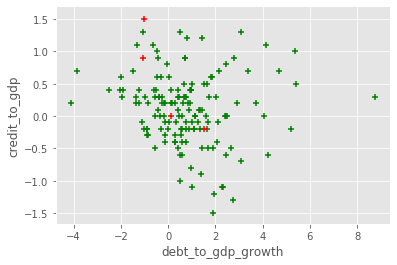

In [188]:
# before fitting models, plot a scatter plot of 'crisis' vs 'non_crisis' data

df1=df[df['crisis']==1]
df0=df[df['crisis']==0]
# randomly pick two factors to plot a scattor to see if there is a kernel to separate crisis/no-crisis in 2D space 
plt.xlabel('debt_to_gdp_growth')
plt.ylabel('credit_to_gdp')
plt.scatter(df0['debt_to_gdp_growth'],df0['credit_to_gdp'],color='green',marker='+')
plt.scatter(df1['debt_to_gdp_growth'],df1['credit_to_gdp'],color='red',marker='+')

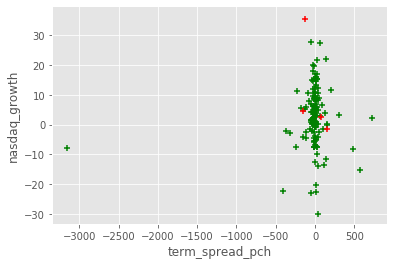

In [189]:
# randomly pick two factors to plot a scattor to see if there is a kernel to separate crisis/no-crisis in 2D space 
plt.xlabel('term_spread_pch')
plt.ylabel('nasdaq_growth')
plt.scatter(df0['term_spread_pch'],df0['nasdaq_growth'],color='green',marker='+')
plt.scatter(df1['term_spread_pch'],df1['nasdaq_growth'],color='red',marker='+')

#### SGD_Classifier

In [190]:
from sklearn.linear_model import SGDClassifier  # SGD_Classifier
sgd_clf=SGDClassifier()
sgd_clf.fit(X_train,y_train)
y_pred=sgd_clf.predict(X_test)

print('recall_score is: '+str(recall_score(y_test,y_pred)))
print('precision_score is: '+str(precision_score(y_test,y_pred)))

# Obviously, linear model SGD is too simple to well explain the dataset.

recall_score is: 0.0
precision_score is: 0.0


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


#### SVM_Classifier

In [191]:
from sklearn.svm import SVC
model=SVC(gamma='auto')
model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [192]:
print('SVM training accuracy is: '+str(model.score(X_train,y_train)))
print('SVM test     accuracy is: '+str(model.score(X_test,y_test)))

# SVM did a good job

SVM training accuracy is: 0.992
SVM test     accuracy is: 1.0


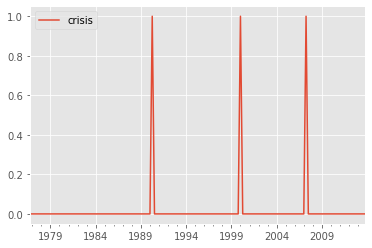

In [193]:
# To visualize SVM  results (test:1970-2007; train:2008-2019)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
crisis=np.concatenate((y_train_pred,y_test_pred), axis=None)
crisis=pd.DataFrame(crisis,index=df.index,columns={'crisis'})
crisis.plot(kind='line')

# In training set, SVM successfully fits the 1990s US recession, 2000 US dotcom bubble bust, and 2008 financial crisis.
# In test set [2008-2019], SVM gave no wrong alert and classify ten years as 'NO-crisis'.
# *** However, in training set, SVM missed the 1970s oil Crisis. 

#### Random Forest

In [194]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [195]:
model.score(X_test,y_test)
#Random Forest did well on test_set
# No overfitting since score_test is 100%

1.0

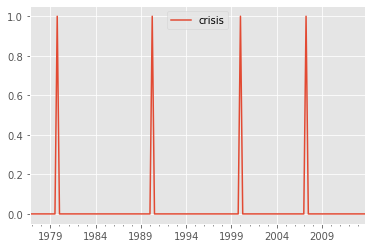

In [196]:
# To visualize RandomForest  results (test:1970-2007; train:2008-2019)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
crisis=np.concatenate((y_train_pred,y_test_pred), axis=None)
crisis=pd.DataFrame(crisis,index=df.index,columns={'crisis'})
crisis.plot(kind='line')

# RandomForest successfully predicts 4 crisis in training set, and it gave no false alarm after 2008, which is good.

In [199]:
model.feature_importances_

array([0.14009113, 0.19820894, 0.0650236 , 0.0828901 , 0.18740292,
       0.11494894, 0.14107912, 0.07035526])

###### Conclusion: The top four indicators for crisis prediction is term_spread(19.8%), nasqad_index_change(18.7%), credit_to_gdp(14%) and         CPI(14%)

###### RandomForest did better than SVM;
Here, Neural Network is absent since the dataset is too small.(only 150 datapoints)